## Introduction
This tutorial will introduce you to one of the most popular, and simple-to-implement machine learning algorithms for classification/regression available: the K-Nearest-Neighbor algorithm. At its core, the algorithm is very simple to not only implement, but also for the average individual to understand, hence, why it is a popular choice of classification for data scientists and machine learning engineers. 

The simplicity and beauty of the algorithm comes from the fact that it closely mirrors the way that humans think: If you have features from a data set (such as how much a student has studied for an exam) all clustered somewhat close to each other with specific labels (such as Pass/Fail), then given a new data point that has features nearby that cluster, classify this data point the same (or similar) label as that of the cluster's. 

Specifically, this algorithm will classify a new data point's label the majority of the 'K' number of nearest neighbors to this data point.

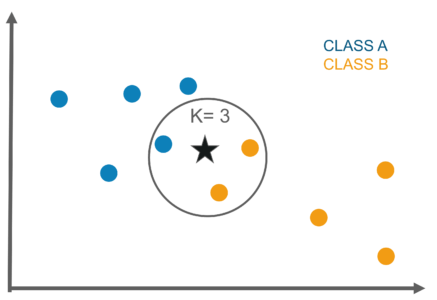

## Tutorial Content
In this tutorial we will explain the KNN algorithm, as well as do some analysis on various datasets with the following steps:
- Explanation of the algorithm
- Setting up the necessary libraries/packages
- Implementing the algorithm
- Finding the best 'K' value
- Plotting the results
- Example Application: UCI ML Wine data set
- Extension: Using KNN for regression
- Summary and further resources

## Explanation of the algorithm

1. Initialize all data you want to be able to 'learn from,' hereby known as the training data, into a data structure.
2. Pick a specific K value, and loop through each data point in a new data set which you want to be able to classify.
3. For each data point, pick a distance metric (for this tutorial we will use Euclidean distance) and store the distance between the point you wish to classify and every single training data point in a list or a numpy array (Note: In general, data scientists say a point can be its own nearest neighbor).
4. Get the 'K' smallest elements from this list. 
5. Use a majority vote classification of the label of these 'K' elements from the list to choose from (if there is a tie, can pick randomly).
6. Repeat steps 3-5 for each new data point you wish to classify.

## Setting up the libraries

For this algorithm, only a few simple libraries are needed: first pip install matplotlib, then import the math library to speed up some math computations, the CSV libary to import csv datasets, the random libary to be able to randomly shuffle our data points for accurate classification, and the matplotlib package to plot the results of our algorithm and to be able to fine tune our 'K' value to choose for our algorithm.


In [ ]:
pip install matplotlib

In [31]:
import math
import csv
import matplotlib.pyplot as plt
import random

## Implementing the algorithm

Initially, we create a function (written below), to read in the dataset and convert it into a 2D list of data, randomly shuffle the data, and then split it into 3 partitions: a training, validation, and test data set. We will use the training data set to train our KNN algorithm, the validation data set to test out different values for 'K' to determine the best value for 'K' that minimizes classification error on the validation data set, and finally, evaluate our performance on the test data. 

This loadAndSplit function also assumes that the data attributes are all continuous valued attributes (i.e all the attributes have some number value, such as amount of money earned in a year), and have a classification label (either binary such as Yes/No or Pass/Fail, or multiclass such as 0/1/2/3 representing different categoriest) as the last element in each row of the data).

For this algorithm, we will split the data set into train/validation/testing data in a 70/30/10 split. Finally, once all the data has been loaded from the CSV file, randomized, and split into 3 sets, we return the three sets as a tuple.

In [32]:
def loadAndSplitData(pathToCsvData):
    #load in all data
    allData = csv.reader(open(pathToCsvData))
    #Now convert all the data into a 2d list
    twoDimensionalListOfData = []
    for row in allData:
        twoDimensionalListOfData += [row]
    listOfColumnNames = twoDimensionalListOfData[0]
    twoDimensionalListOfData = twoDimensionalListOfData[1:]
    random.seed(0)
    random.shuffle(twoDimensionalListOfData)
    indexForTrainingData = int(0.7 * len(twoDimensionalListOfData))
    indexForValidationData = int(0.2 * len(twoDimensionalListOfData)) + indexForTrainingData
    indexForTestingData = int(0.1 * len(twoDimensionalListOfData)) + indexForValidationData
    trainingData = twoDimensionalListOfData[0:indexForTrainingData]
    validationData = twoDimensionalListOfData[indexForTrainingData: indexForValidationData]
    testData = twoDimensionalListOfData[indexForValidationData:]
    #and return it as a tuple
    return (trainingData, validationData, testData)

Now that we have successfully loaded and split the data, we need a distance metric to give a good measurement of how 'far' a new unseen example may be from each point in our training data. 

There are many options for distance metrics possible for the K-Nearest-Neighbors algorithm  but we are going to use the most standard one:

**Euclidean Distance**:
    Euclidean Distance is the traditional distance metric you may be used to from geometry class. In 2-dimensions, the formula is \begin{equation*}
distance = \sqrt{(y_{2} - y_{1})^2 + (x_{2} - x_{1})^2}
\end{equation*}

However, in data science, the data is almost always more than 2-dimensions, so all we must do for Euclidean distance in this case is extend the formula to be the square root of the sum of all the attributes in example 1 minus the sum of all the attributes in example 2:
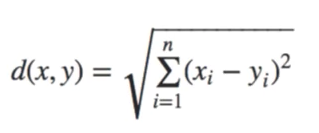


For the purposes of our algorithm, we are going to use Euclidean distance to keep our distance metric simple, yet accurate. 
In code, all we must do is given 2 examples (an unseen example we want to classify, and a specific row of our training data), go through each of their attributes, and sum up the difference in values squared. Finally, we return the square root of the sum.

In [33]:
def distanceBetweenTwoExamples(example1,example2):
    distance = 0.0
    for value1, value2 in zip(example1, example2):
        distance += ((float(value2) - float(value1))**2)
    distance = math.sqrt(distance)
    return distance       

Next, for modularity, we will create a function that when given the 'K' number of closest data points as a list from the training data set, we will give back the most common label found among them (or commonly known as, the 'mode' of the labels). In the case of a tie, we rely on Python's dictionary hashing behavior to randomly give us back a label from among the most popular of the labels found. From the 'K' closest data points, we can store their labels in a dictionary as a key, and the number of times each label occurs in the 'K' closest lists as the value to efficiently get the most popular label from the 'K' closest lists. 

In [34]:
def getMajorityOfLabels(kClosestLists):
    dictOfLabels = dict()
    for distanceAndLabel in kClosestLists:
        label = distanceAndLabel[1]
        if(label in dictOfLabels):
            dictOfLabels[label] += 1
        else:
            dictOfLabels[label] = 1
    return(max(dictOfLabels, key=dictOfLabels.get))

Next, we can write an additional helper function to do the brunt of the work for the KNN algorithm. Given the training data, a specific data point we wish to classify, and our 'K' value:
1. Go through each data point in our training data and store its distance from our new data point (with the help of our distance function above) and store its distance and the label of the training data point as a tuple in a list.
2. Sort the (distance, label) list from the training data point by the distance value. 
3. From the (distance, label) sorted list, extract the first 'K' of them.
4. Using our majority label function above, get the 'mode' of the 'K' closest data points' labels and return it.

In [35]:
def predictLabelForEachNewExample(trainingData, example, kValue):
    listOfDistancesAndLabels = []
    for eachRow in trainingData:
        listOfDistancesAndLabels += [(distanceBetweenTwoExamples(eachRow[:-1], example[:-1]), (eachRow[-1]))]
    listOfDistancesAndLabels.sort(key = lambda a:a[0])
    kClosestLists = listOfDistancesAndLabels[:kValue]
    label = getMajorityOfLabels(kClosestLists)
    return(label)

Finally, we can write a last helper function to complete our K-Nearest-Neighbors function that would go through a new data set (either the validation or test dataset), and return a final list of predicted labels for the new data set. 

In [36]:
def getLabelsOfAllExamplesInData(trainingData, validationOrTestData, kValue):
    listOfLabels = []
    for eachRow in validationOrTestData:
        listOfLabels += [(predictLabelForEachNewExample(trainingData, eachRow, kValue))]
    return(listOfLabels)

## Finding the best K value

Now that the KNN algorithm is complete, what value of 'K' is actually ideal for a specific data set? To find this ideal 'K,' we take advantage of the fact that we have split our data into 3 sub-partitions: we used our training data set to actually fit the model of our KNN algorithm, but now we use our validation data set as a 'helper' data set to actually figure out what the ideal 'K' value is with the following steps:
1. See how well we do with our validation data set when we try to predict the label of each data point for each value of 'K'
2. Store a corresponding 'error rate' to see the proportion of label predictions we got wrong as compared to the validation data's true labels for each 'K' value
3. Plot the 'K' value vs. the error rate
4. Pick the 'K' that seems to minimize the error rate on the graph (also known as local minimum)
5. If you find multiple 'K' values that have extremely similar low error rates, pick the smallest 'K' to follow Occam's Razor which states given multiple answers which point to the same (or extremely similar) answers, pick the simplest one. (in this case the simplest means the smallest 'K' value)
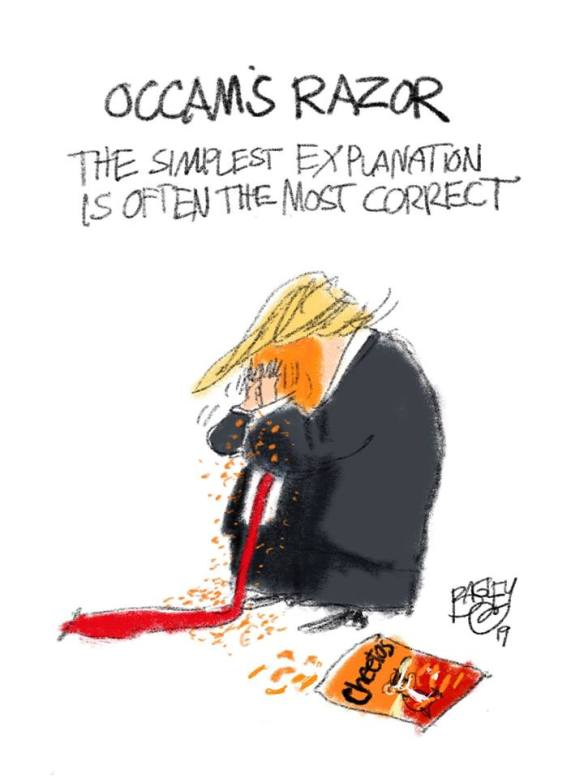



We can now write two helper functions which gets the error rate when given a list of predict labels, and the true labels, as well as another which gets the labels from a data set. 

In [37]:
def getErrorRate(listOfPredictedLabels, listOfTrueLabels):
    misses = 0
    for trialNum in range(len(listOfPredictedLabels)):
        if(listOfPredictedLabels[trialNum] != listOfTrueLabels[trialNum]):
            misses += 1
    return(float(misses) / float(len(listOfPredictedLabels)))

def getLabelsFromData(data):
    listOfLabels = []
    for dataRow in data:
        listOfLabels += [(dataRow[-1])]
    return(listOfLabels)

## Plotting the results

Lastly, we write the main function which will take in all 3 partitions of data, and plot the error of data for all 3 partitions for different values of 'K' from 1 to the number of data points in the validation data set in increments of 5%. Once we have a graph for both the training and validation error, we can pick the simplest value for 'K' that minimizes the validation error for our data set through a visual inspection.
So, for example: if our graph for validation error vs. K-value looked like this:

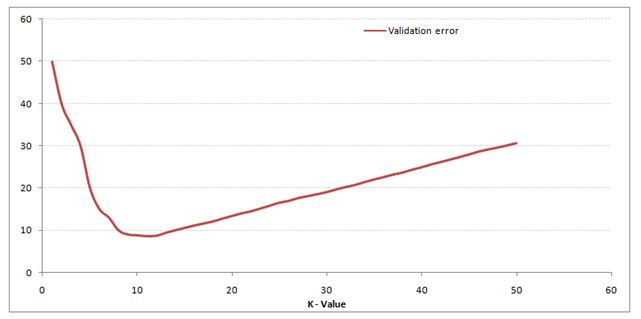



then we would pick the simplest, local minimum at about K=9 as the selected K-value.




**NOTE: because this function may take about a minute to run, we include a print statement to print to the console the progress of the algorithm**

In [38]:
def plotDifferentErrors(trainingData, validationData):
    kList = []
    errorList = []
    errorList2 = []
    for k in range(1,len(trainingData), len(trainingData) // 20):
        print("%d percent done" % ((float(k) / float(len(trainingData))) * 100))
        a = getLabelsOfAllExamplesInData(trainingData, trainingData,k)
        aa = getLabelsOfAllExamplesInData(trainingData, validationData, k)
        b = getLabelsFromData(trainingData)
        c = getLabelsFromData(validationData)
        errorRate = getErrorRate(a,b)
        errorRate2 = getErrorRate(aa,c)
        #errorRate2 = getErrorRate(aa,bb)
        kList += [k]
        errorList += [errorRate]
        errorList2 += [errorRate2]
    plt.plot(kList, errorList, label="Training data")
    plt.plot(kList, errorList2,label="Validation data")
    plt.legend()
    plt.ylabel("Error rate")
    plt.xlabel("K value")
    plt.show()

## **Example Application: UCI ML Wine data set**

Our first dataset we will be working with is a classic one used in data science coursework, particularly one that data scientists often use to train new models/algorithms.

The data set comes from the Machine Learning Repository from University of California at Irvine's data repository on predicting wine quality (a score from a scale of 0-10) based on 11 attributes:
1. Fixed acidity amount
2. Volatile acidity
3. Citric acid
4. Residual sugar
5. Chlorides
6. Free sulfur dioxide
7. Total sulfur dioxide
8. Density
9. PH level
10. Sulphates
11. Alcohol amount

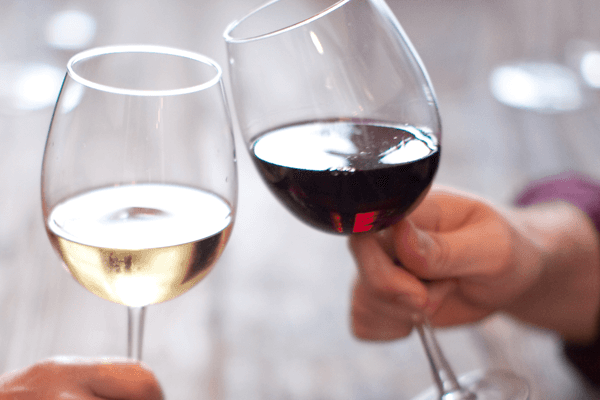

The data contains 600 examples which we will split into 3 different partitions: the training data set (420 examples), a validation data set (120 examples), and a testing data set (60 examples). The training data set will be used to  train our algorithm, the validation data set will be used as to find out best 'K' value, while our testing data set will be a final measurement of how well we did with our algorithm for our newly chosen 'K'.

For this data set, the data points are not properly formatted, as the separate attributes appear as if it was 1 attribute, separated by a semicolon (i.e each row appears in the format: "7.9;0.18;0.37;1.2;0.04;16;75;0.992;3.18;0.63;10.8;5") so we make a slight modification to our loadAndSplitData function to split by ';'.

In [39]:
def loadAndSplitDataWine(pathToCsvData):
    allData = csv.reader(open(pathToCsvData))
    twoDimensionalListOfData = []
    for row in allData:
        #make the change here!
        twoDimensionalListOfData += [row[0].split(";")]
    listOfColumnNames = twoDimensionalListOfData[0]
    twoDimensionalListOfData = twoDimensionalListOfData[1:]
    trainingData = twoDimensionalListOfData[0:420]
    validationData = twoDimensionalListOfData[420:540]
    testData = twoDimensionalListOfData[540:600]
    return (trainingData, validationData, testData)

Now, we load in all 3 of our data partitions, and run the plot function to find an optimal value of 'K'. Once we have that, we can measure our performance on our testing data. 

**NOTE: running this cell block below may take about a minute**

0 percent done
5 percent done
10 percent done
15 percent done
20 percent done
25 percent done
30 percent done
35 percent done
40 percent done
45 percent done
50 percent done
55 percent done
60 percent done
65 percent done
70 percent done
75 percent done
80 percent done
85 percent done
90 percent done
95 percent done


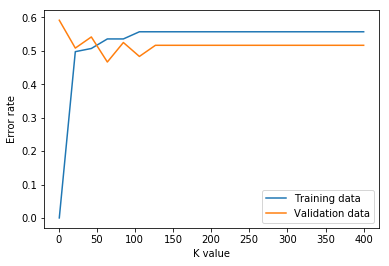

In [40]:
trainingData = loadAndSplitDataWine("winequality-white.csv")[0]
validationData = loadAndSplitDataWine("winequality-white.csv")[1]
testData = loadAndSplitDataWine("winequality-white.csv")[2]
plotDifferentErrors(trainingData, validationData)

Looking at the plot above, we see that at a K value of 1, the training error is 0. This demonstrates the property of the KNN algorithm that the lower the value of K, the greater the overfitting, while a greater K value will underfit. Furthermore, since we seek to minimize validation data error to give us good performance on the test data, we see that at K values of around 63, 78, and 86, we see minimums in the validation data until it begins to increase. But, as described above, by Occam's Razor, we will choose a K value of 63. Also, picking an odd value of K makes breaking ties much simpler for the algorithm. Now, we can create a quick function to evaluate just our test performance for different values of K.

In [41]:
def plotTestError(trainingData, testingData):
    kList = []
    errorList = []
    for k in range(1,len(trainingData), len(trainingData) // 20):
        print("%d percent done" % ((float(k) / float(len(trainingData))) * 100))
        a = getLabelsOfAllExamplesInData(trainingData, testingData,k)
        b = getLabelsFromData(testingData)
        errorRate = getErrorRate(a,b)
        kList += [k]
        errorList += [errorRate]
    plt.plot(kList, errorList, label="Testing data")
    plt.legend()
    plt.ylabel("Error rate")
    plt.xlabel("K value")
    plt.show()

0 percent done
5 percent done
10 percent done
15 percent done
20 percent done
25 percent done
30 percent done
35 percent done
40 percent done
45 percent done
50 percent done
55 percent done
60 percent done
65 percent done
70 percent done
75 percent done
80 percent done
85 percent done
90 percent done
95 percent done


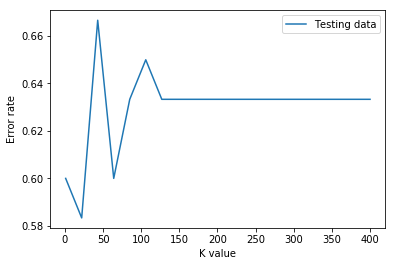

In [42]:
plotTestError(trainingData, testData)

Looking at the graph above, we see that at about K=63, we hit one of the local minimums of 0.60~ as our error rate, which indicates that our method of using a validation data set to pick a value of K was indeed quite effective.

**NOTE:** While one may be tempted to think "If our goal is to try and perform as well as possible and minimize test data error, why don't we just tune our K to minimize testing error rather than validation error if that is our end goal?"

Unfortunately, this is a problem of great anguish among the data science as it is **CHEATING.** In data science/machine learning, we don't actually have access to the testing data, so trying to look at the testing data and its labels to tune your model is not allowed, as test data is new data which we are expected to be able to accurately classify. So, this is why we only can look at the values of our training data, and split it into validation data as well to tune our 'K' value, and then use our test data as a final measurement of performance to see how well we did in the end. 

## Extension: Using KNN for regression

Another reason why the K-Nearest-Neighbors algorithm is a popular choice among data scientists is due to its ability to easily be expanded into regression problems. For regression, the difference will now be that when you have your 'K-closest' elements, and are trying to predict the value of the label for a new data point which could be any real-valued number now, you will take the average of the values of the labels of the 'K-closest' elements. 

This can be implemented by changing up our 'getMajorityOfLabels':

In [45]:
#kClosestLists is a list of tuples of the 'K' closest (distance, label)
def getMajorityOfLabelsForRegression(kClosestLists):
    kClosestLists = kClosestLists.sort(key = lambda a:a[0])
    listOfLabels = []
    for distanceAndLabel in kClosestLists:
        listOfLabels += [distanceAndLabel[1]]
    sumOfkClosestLabels = 0.0
    for label in listOfLabels:
        sumOfkClosestLabels += float(label)
    averagedValueForOutout = sumOfkClosestLabels / float(len(listOfLabels))
    return(averagedValueForOutout)

## Summary and further resources

Overall, the K-Nearest-Neighbor algorithm is an extremely popular choice for data scientists in practice, as well as for teaching the foundations of machine learning in introductory coursework, due to its simplicity, its ability to do binary or multi-class classification problems, as well as being able to easily expand out to regression problems with slight modifications such as above. 

But, perhaps due in part to it simplicity of implementation, for very large datasets, the runtime will increase proportional to M (the length of the training data) and N (number of dimensions in the training data), giving an overall complexity of O(MN) for each new data point you wish to classify. This gives rise to what is known popularly by machine learning engineers as the "curse of dimensionality" where as the number of dimensions of the attribute variable (or 'X') increases, the KNN algorithm will become considerably slower for the label variable (or 'Y'). 

For additional resources on the KNN algorithm and its variations/extensions consider browsing through:
- The weighted KNN algorithm: https://www.geeksforgeeks.org/weighted-k-nn/
- Additional distance metrics for KNN: https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
- Decision boundaries for KNN: http://www-personal.umd.umich.edu/~leortiz/teaching/6.034f/Fall06/knn_dt/nn-bounds+soln.pdf
- Impact of outliers on KNN: https://www.jmp.com/support/help/14-2/multivariate-k-nearest-neighbor-outliers.shtml

Lastly, the citations for the pictures and dataset are below:
- https://www.google.com/url?sa=i&source=images&cd=&ved=2ahUKEwiM-Yj72J7lAhUwUt8KHSlwAysQjRx6BAgBEAQ&url=https%3A%2F%2Fwww.edureka.co%2Fblog%2Fk-nearest-neighbors-algorithm%2F&psig=AOvVaw2nSbFM8Ph_cqqJzHT-1dHl&ust=1571243666500868
- https://towardsdatascience.com/importance-of-distance-metrics-in-machine-learning-modelling-e51395ffe60d
- https://ventrellaquest.com/2019/02/06/occams-razor/
- https://archive.ics.uci.edu/ml/datasets/Wine
- https://trustarts.org/production/60224/wednesday-wine-flights-annual-holiday-wine-and-cheese